In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')
import xgboost as xgb
import pickle
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [2]:
sample_df = pd.read_csv("train.csv")

In [3]:
sample_df.shape

(1048575, 11)

In [4]:
print("There are %d unique id's in Training dataset, which is equal to the number of records"%(sample_df.id.nunique()))

There are 1048575 unique id's in Training dataset, which is equal to the number of records


In [5]:
sample_df.isnull().sum()


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
sample_df.head(15)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,14-03-2016 17:24,14-03-2016 17:32,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,12-06-2016 00:43,12-06-2016 00:54,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,19-01-2016 11:35,19-01-2016 12:10,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,06-04-2016 19:32,06-04-2016 19:39,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,26-03-2016 13:30,26-03-2016 13:38,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,30-01-2016 22:01,30-01-2016 22:09,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,17-06-2016 22:34,17-06-2016 22:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,21-05-2016 07:54,21-05-2016 08:20,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,27-05-2016 23:12,27-05-2016 23:16,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,10-03-2016 21:45,10-03-2016 22:05,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [7]:
sample_df["store_and_fwd_flag"].value_counts()

N    1042766
Y       5809
Name: store_and_fwd_flag, dtype: int64

In [8]:
pd.options.display.float_format = '{:.2f}'.format #To suppres scientific notation.
sample_df.passenger_count.value_counts()



1    743132
2    151078
5     56252
3     43033
6     34700
4     20336
0        39
7         3
9         1
8         1
Name: passenger_count, dtype: int64

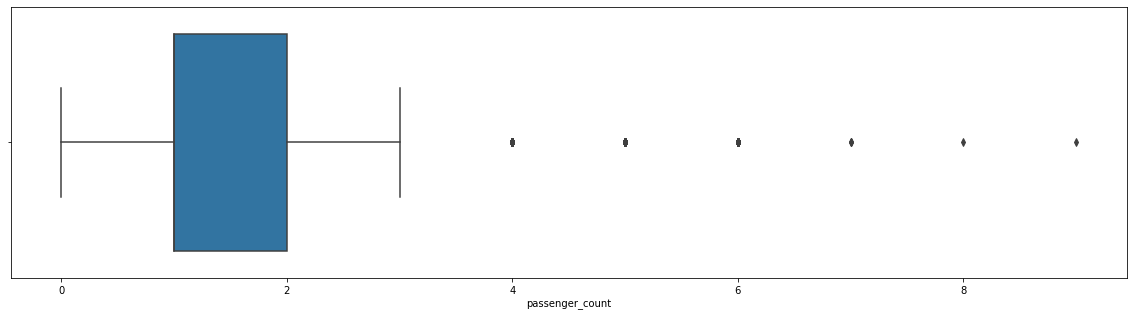

In [9]:
plt.figure(figsize = (20,5))
sns.boxplot(sample_df.passenger_count)
plt.show()

In [10]:
 f = lambda x: 0 if x == 'N' else 1

sample_df["store_and_fwd_flag"] = sample_df["store_and_fwd_flag"].apply(lambda x: f(x))            

In [11]:
#Results
sample_df["store_and_fwd_flag"].value_counts()

0    1042766
1       5809
Name: store_and_fwd_flag, dtype: int64

In [12]:
sample_df.store_and_fwd_flag.value_counts(normalize=True)

0   0.99
1   0.01
Name: store_and_fwd_flag, dtype: float64

In [13]:
#datetime conversion
sample_df["dropoff_datetime"] = pd.to_datetime(sample_df["dropoff_datetime"], format='%d-%m-%Y %H:%M')
sample_df["pickup_datetime"] = pd.to_datetime(sample_df["pickup_datetime"], format='%d-%m-%Y %H:%M')

In [14]:
#month,date
sample_df["pickup_month"] = sample_df["pickup_datetime"].dt.month
sample_df["pickup_day"] = sample_df["pickup_datetime"].dt.day
sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday 
sample_df["pickup_hour"] = sample_df["pickup_datetime"].dt.hour
sample_df["pickup_minute"] = sample_df["pickup_datetime"].dt.minute

In [15]:
#Get latitude and longitude differences 
sample_df["latitude_difference"] = sample_df["dropoff_latitude"] - sample_df["pickup_latitude"]
sample_df["longitude_difference"] = sample_df["dropoff_longitude"] - sample_df["pickup_longitude"]

In [16]:
#Convert duration into mins
sample_df["trip_duration"] = sample_df["trip_duration"].apply(lambda x: round(x/60))   

In [17]:
#Converting trip distance from longitude and latitude differences to distance
sample_df["trip_distance"] = 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(sample_df["latitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(sample_df["latitude_difference"]) * np.pi / 180) / 2)))))) + \
                                     abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(sample_df["longitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(sample_df["longitude_difference"]) * np.pi / 180) / 2)))))))

In [18]:
sample_df.head(17)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference,trip_distance
0,id2875421,2,2016-03-14 17:24:00,2016-03-14 17:32:00,1,-73.98,40.77,-73.96,40.77,0,8,3,14,0,17,24,-0.00,0.02,1.37
1,id2377394,1,2016-06-12 00:43:00,2016-06-12 00:54:00,1,-73.98,40.74,-74.00,40.73,0,11,6,12,6,0,43,-0.01,-0.02,1.83
2,id3858529,2,2016-01-19 11:35:00,2016-01-19 12:10:00,1,-73.98,40.76,-74.01,40.71,0,35,1,19,1,11,35,-0.05,-0.03,5.54
3,id3504673,2,2016-04-06 19:32:00,2016-04-06 19:39:00,1,-74.01,40.72,-74.01,40.71,0,7,4,6,2,19,32,-0.01,-0.00,1.07
4,id2181028,2,2016-03-26 13:30:00,2016-03-26 13:38:00,1,-73.97,40.79,-73.97,40.78,0,7,3,26,5,13,30,-0.01,0.00,0.75
5,id0801584,2,2016-01-30 22:01:00,2016-01-30 22:09:00,6,-73.98,40.74,-73.99,40.75,0,7,1,30,5,22,1,0.01,-0.01,1.12
6,id1813257,1,2016-06-17 22:34:00,2016-06-17 22:40:00,4,-73.97,40.76,-73.96,40.77,0,6,6,17,4,22,34,0.01,0.01,1.36
7,id1324603,2,2016-05-21 07:54:00,2016-05-21 08:20:00,1,-73.97,40.80,-73.92,40.76,0,26,5,21,5,7,54,-0.04,0.05,5.81
8,id1301050,1,2016-05-27 23:12:00,2016-05-27 23:16:00,1,-74.00,40.74,-73.99,40.73,0,4,5,27,4,23,12,-0.01,0.01,1.33
9,id0012891,2,2016-03-10 21:45:00,2016-03-10 22:05:00,1,-73.98,40.74,-73.97,40.79,0,20,3,10,3,21,45,0.05,0.01,3.71


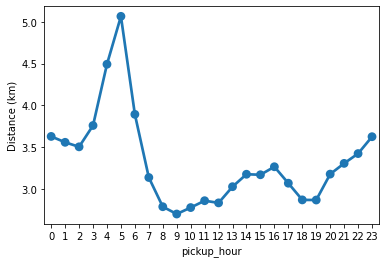

In [19]:
group5 = sample_df.groupby('pickup_hour').trip_distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (km)')
plt.show()

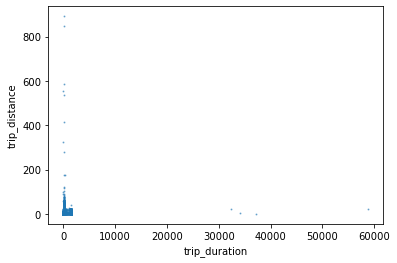

In [20]:
#trip distance vs duration
plt.scatter(sample_df.trip_duration, sample_df.trip_distance , s=1, alpha=0.5)
plt.ylabel('trip_distance')
plt.xlabel('trip_duration')
plt.show()

In [21]:
X = sample_df.drop(["trip_duration", "id", "vendor_id", "pickup_datetime", "dropoff_datetime"], axis=1)
y = sample_df["trip_duration"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.35, random_state=2019)

In [23]:
#Evaluation metric
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [24]:
#XGBoost parameters 
params = {
    'booster':            'gbtree',
    'objective':          'reg:linear',
    'learning_rate':      0.1,
    'max_depth':          14,
    'subsample':          0.9,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1,
    'feval':              'rmsle'
}

In [25]:
#epochs
nrounds = 1300

In [26]:
#Define train and validation sets
dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
dval = xgb.DMatrix(X_val, np.log(y_val+1))


watchlist = [(dval, 'eval'), (dtrain, 'train')]

In [27]:
#Train model
gbm = xgb.train(params,
                dtrain,
                num_boost_round = nrounds,
                evals = watchlist,
                verbose_eval = True
                )
gbm

[19:33:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { feval, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:1.90545	train-rmse:1.90382
[1]	eval-rmse:1.72452	train-rmse:1.72301
[2]	eval-rmse:1.56252	train-rmse:1.56091
[3]	eval-rmse:1.41692	train-rmse:1.41472
[4]	eval-rmse:1.28914	train-rmse:1.28654
[5]	eval-rmse:1.17517	train-rmse:1.17222
[6]	eval-rmse:1.07188	train-rmse:1.06831
[7]	eval-rmse:0.97937	train-rmse:0.97446
[8]	eval-rmse:0.89865	train-rmse:0.89275
[9]	eval-rmse:0.82519	train-rmse:0.81722
[10]	eval-rmse:0.76042

[180]	eval-rmse:0.34208	train-rmse:0.16085
[181]	eval-rmse:0.34207	train-rmse:0.16055
[182]	eval-rmse:0.34205	train-rmse:0.15991
[183]	eval-rmse:0.34205	train-rmse:0.15982
[184]	eval-rmse:0.34205	train-rmse:0.15957
[185]	eval-rmse:0.34206	train-rmse:0.15937
[186]	eval-rmse:0.34205	train-rmse:0.15903
[187]	eval-rmse:0.34204	train-rmse:0.15870
[188]	eval-rmse:0.34204	train-rmse:0.15849
[189]	eval-rmse:0.34205	train-rmse:0.15829
[190]	eval-rmse:0.34201	train-rmse:0.15774
[191]	eval-rmse:0.34201	train-rmse:0.15755
[192]	eval-rmse:0.34201	train-rmse:0.15729
[193]	eval-rmse:0.34200	train-rmse:0.15712
[194]	eval-rmse:0.34200	train-rmse:0.15676
[195]	eval-rmse:0.34198	train-rmse:0.15611
[196]	eval-rmse:0.34197	train-rmse:0.15580
[197]	eval-rmse:0.34196	train-rmse:0.15556
[198]	eval-rmse:0.34197	train-rmse:0.15539
[199]	eval-rmse:0.34196	train-rmse:0.15517
[200]	eval-rmse:0.34197	train-rmse:0.15473
[201]	eval-rmse:0.34196	train-rmse:0.15429
[202]	eval-rmse:0.34197	train-rmse:0.15389
[203]	eval-

[371]	eval-rmse:0.34164	train-rmse:0.11673
[372]	eval-rmse:0.34164	train-rmse:0.11657
[373]	eval-rmse:0.34164	train-rmse:0.11645
[374]	eval-rmse:0.34164	train-rmse:0.11642
[375]	eval-rmse:0.34164	train-rmse:0.11618
[376]	eval-rmse:0.34162	train-rmse:0.11582
[377]	eval-rmse:0.34163	train-rmse:0.11567
[378]	eval-rmse:0.34162	train-rmse:0.11544
[379]	eval-rmse:0.34162	train-rmse:0.11532
[380]	eval-rmse:0.34163	train-rmse:0.11507
[381]	eval-rmse:0.34163	train-rmse:0.11495
[382]	eval-rmse:0.34163	train-rmse:0.11485
[383]	eval-rmse:0.34163	train-rmse:0.11469
[384]	eval-rmse:0.34163	train-rmse:0.11456
[385]	eval-rmse:0.34161	train-rmse:0.11427
[386]	eval-rmse:0.34161	train-rmse:0.11406
[387]	eval-rmse:0.34159	train-rmse:0.11362
[388]	eval-rmse:0.34159	train-rmse:0.11347
[389]	eval-rmse:0.34159	train-rmse:0.11345
[390]	eval-rmse:0.34159	train-rmse:0.11331
[391]	eval-rmse:0.34159	train-rmse:0.11322
[392]	eval-rmse:0.34159	train-rmse:0.11314
[393]	eval-rmse:0.34159	train-rmse:0.11304
[394]	eval-

[562]	eval-rmse:0.34168	train-rmse:0.09153
[563]	eval-rmse:0.34168	train-rmse:0.09150
[564]	eval-rmse:0.34169	train-rmse:0.09132
[565]	eval-rmse:0.34169	train-rmse:0.09124
[566]	eval-rmse:0.34168	train-rmse:0.09115
[567]	eval-rmse:0.34168	train-rmse:0.09108
[568]	eval-rmse:0.34168	train-rmse:0.09098
[569]	eval-rmse:0.34168	train-rmse:0.09088
[570]	eval-rmse:0.34168	train-rmse:0.09080
[571]	eval-rmse:0.34168	train-rmse:0.09067
[572]	eval-rmse:0.34168	train-rmse:0.09060
[573]	eval-rmse:0.34168	train-rmse:0.09045
[574]	eval-rmse:0.34168	train-rmse:0.09035
[575]	eval-rmse:0.34168	train-rmse:0.09030
[576]	eval-rmse:0.34168	train-rmse:0.09021
[577]	eval-rmse:0.34168	train-rmse:0.09017
[578]	eval-rmse:0.34169	train-rmse:0.09005
[579]	eval-rmse:0.34169	train-rmse:0.08997
[580]	eval-rmse:0.34169	train-rmse:0.08992
[581]	eval-rmse:0.34169	train-rmse:0.08986
[582]	eval-rmse:0.34168	train-rmse:0.08974
[583]	eval-rmse:0.34169	train-rmse:0.08968
[584]	eval-rmse:0.34169	train-rmse:0.08948
[585]	eval-

[753]	eval-rmse:0.34178	train-rmse:0.07432
[754]	eval-rmse:0.34178	train-rmse:0.07422
[755]	eval-rmse:0.34179	train-rmse:0.07412
[756]	eval-rmse:0.34179	train-rmse:0.07404
[757]	eval-rmse:0.34178	train-rmse:0.07398
[758]	eval-rmse:0.34178	train-rmse:0.07386
[759]	eval-rmse:0.34178	train-rmse:0.07385
[760]	eval-rmse:0.34179	train-rmse:0.07379
[761]	eval-rmse:0.34179	train-rmse:0.07370
[762]	eval-rmse:0.34179	train-rmse:0.07365
[763]	eval-rmse:0.34179	train-rmse:0.07359
[764]	eval-rmse:0.34178	train-rmse:0.07344
[765]	eval-rmse:0.34178	train-rmse:0.07316
[766]	eval-rmse:0.34178	train-rmse:0.07303
[767]	eval-rmse:0.34178	train-rmse:0.07299
[768]	eval-rmse:0.34178	train-rmse:0.07293
[769]	eval-rmse:0.34178	train-rmse:0.07281
[770]	eval-rmse:0.34178	train-rmse:0.07271
[771]	eval-rmse:0.34178	train-rmse:0.07251
[772]	eval-rmse:0.34178	train-rmse:0.07245
[773]	eval-rmse:0.34178	train-rmse:0.07236
[774]	eval-rmse:0.34178	train-rmse:0.07226
[775]	eval-rmse:0.34178	train-rmse:0.07221
[776]	eval-

[944]	eval-rmse:0.34186	train-rmse:0.06000
[945]	eval-rmse:0.34187	train-rmse:0.05993
[946]	eval-rmse:0.34187	train-rmse:0.05987
[947]	eval-rmse:0.34186	train-rmse:0.05977
[948]	eval-rmse:0.34186	train-rmse:0.05971
[949]	eval-rmse:0.34186	train-rmse:0.05966
[950]	eval-rmse:0.34186	train-rmse:0.05961
[951]	eval-rmse:0.34186	train-rmse:0.05955
[952]	eval-rmse:0.34186	train-rmse:0.05949
[953]	eval-rmse:0.34186	train-rmse:0.05945
[954]	eval-rmse:0.34186	train-rmse:0.05940
[955]	eval-rmse:0.34186	train-rmse:0.05929
[956]	eval-rmse:0.34186	train-rmse:0.05924
[957]	eval-rmse:0.34186	train-rmse:0.05918
[958]	eval-rmse:0.34186	train-rmse:0.05909
[959]	eval-rmse:0.34187	train-rmse:0.05895
[960]	eval-rmse:0.34186	train-rmse:0.05887
[961]	eval-rmse:0.34187	train-rmse:0.05880
[962]	eval-rmse:0.34187	train-rmse:0.05874
[963]	eval-rmse:0.34187	train-rmse:0.05872
[964]	eval-rmse:0.34187	train-rmse:0.05866
[965]	eval-rmse:0.34187	train-rmse:0.05860
[966]	eval-rmse:0.34187	train-rmse:0.05855
[967]	eval-

[1132]	eval-rmse:0.34192	train-rmse:0.04916
[1133]	eval-rmse:0.34192	train-rmse:0.04910
[1134]	eval-rmse:0.34192	train-rmse:0.04905
[1135]	eval-rmse:0.34192	train-rmse:0.04896
[1136]	eval-rmse:0.34192	train-rmse:0.04893
[1137]	eval-rmse:0.34192	train-rmse:0.04887
[1138]	eval-rmse:0.34192	train-rmse:0.04883
[1139]	eval-rmse:0.34192	train-rmse:0.04879
[1140]	eval-rmse:0.34192	train-rmse:0.04877
[1141]	eval-rmse:0.34192	train-rmse:0.04871
[1142]	eval-rmse:0.34192	train-rmse:0.04869
[1143]	eval-rmse:0.34192	train-rmse:0.04866
[1144]	eval-rmse:0.34192	train-rmse:0.04861
[1145]	eval-rmse:0.34192	train-rmse:0.04859
[1146]	eval-rmse:0.34192	train-rmse:0.04856
[1147]	eval-rmse:0.34192	train-rmse:0.04852
[1148]	eval-rmse:0.34192	train-rmse:0.04848
[1149]	eval-rmse:0.34192	train-rmse:0.04842
[1150]	eval-rmse:0.34192	train-rmse:0.04840
[1151]	eval-rmse:0.34192	train-rmse:0.04836
[1152]	eval-rmse:0.34192	train-rmse:0.04827
[1153]	eval-rmse:0.34192	train-rmse:0.04822
[1154]	eval-rmse:0.34192	train-r

In [28]:
#Test predictions
pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1

In [29]:
#Mean absolute error 
mae = (abs(pred - y_test)).mean()
mae

4.992839813232422

In [30]:
#Take a look at feature importance
feature_scores = gbm.get_fscore()
feature_scores

{'latitude_difference': 258574,
 'trip_distance': 235310,
 'pickup_latitude': 394640,
 'pickup_weekday': 118884,
 'dropoff_longitude': 337752,
 'passenger_count': 127034,
 'pickup_month': 128260,
 'store_and_fwd_flag': 2328,
 'pickup_minute': 216817,
 'longitude_difference': 239622,
 'pickup_longitude': 430878,
 'pickup_day': 207610,
 'dropoff_latitude': 317953,
 'pickup_hour': 182169}

In [31]:
#Feature Scaling
summ = 0
for key in feature_scores:
    summ = summ + feature_scores[key]

for key in feature_scores:
    feature_scores[key] = feature_scores[key] / summ

feature_scores

{'latitude_difference': 0.08085918236454646,
 'trip_distance': 0.07358425132535147,
 'pickup_latitude': 0.1234086479241711,
 'pickup_weekday': 0.03717644866160845,
 'dropoff_longitude': 0.10561908993939954,
 'passenger_count': 0.03972505113622327,
 'pickup_month': 0.04010843599927576,
 'store_and_fwd_flag': 0.0007279934430556212,
 'pickup_minute': 0.06780126904767637,
 'longitude_difference': 0.07493266529719676,
 'pickup_longitude': 0.13474070393338486,
 'pickup_day': 0.06492213003126182,
 'dropoff_latitude': 0.09942770584186594,
 'pickup_hour': 0.05696642505498258}

In [32]:
#saving the model
filename = "xgb.sav"
pickle.dump(gbm, open(filename, 'wb'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Gain', ylabel='Features'>

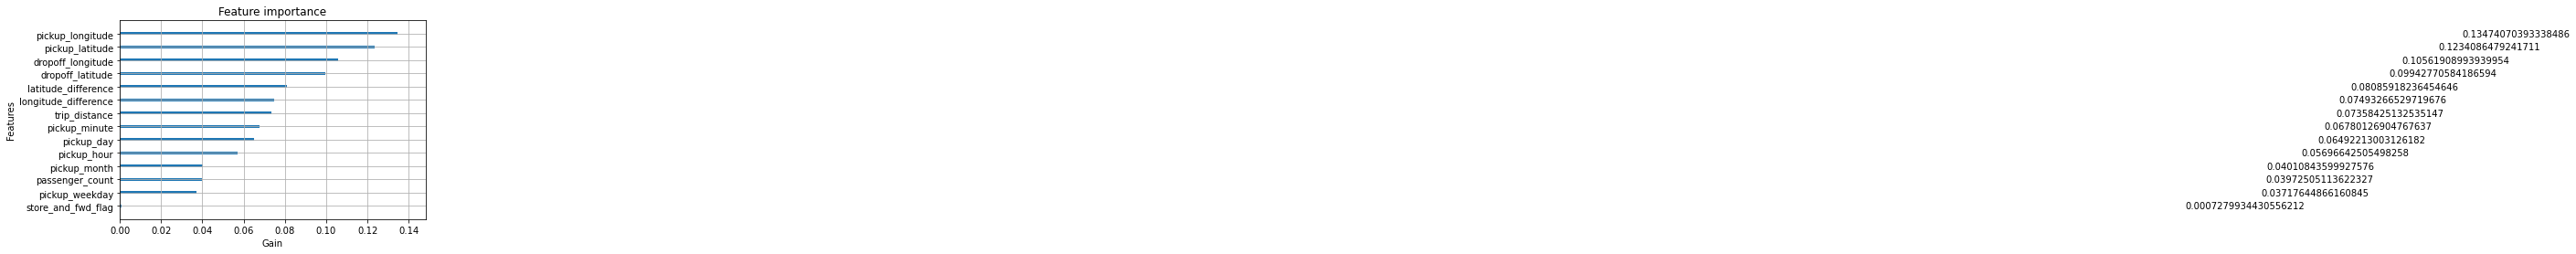

In [33]:
xgb.plot_importance(feature_scores,importance_type='gain',xlabel='Gain')